In [158]:
#define html style element for notebook formatting
from IPython.core.display import HTML 
with open('style.txt', 'r') as myfile:
    notebook_style = myfile.read().replace('\n', '') 
HTML(notebook_style);

In [159]:
#some relevant imports and some magic

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

## MNIST Classification Example

In [160]:
def PrepareData(X, y, n_classes):
    # one hot encode Ys
    Y_ohe = np.zeros((y.size, n_classes))
    Y_ohe[np.arange(y.size),y] = 1

    #transpose data 
    X = X.T
    Y_ohe = Y_ohe.T

    ## randomly shuffle columns (examples)
    random_perm_of_cols = np.random.RandomState(seed=42).permutation(X.shape[1])
    X = X[:, random_perm_of_cols]
    Y_ohe = Y_ohe[:, random_perm_of_cols]
    
    return X, Y_ohe

In [161]:
def displayData(X, examples, labels=None, cmap='gray_r'):
    # set up array
    fig, ax = plt.subplots(nrows=examples.shape[0], ncols=examples.shape[1], 
                           figsize=(20,10))
    # loop over randomly drawn numbers
    for i in range(examples.shape[0]):
        for j in range(examples.shape[1]):
            ind = examples[i, j]
            
            tmp = X[:, ind].reshape(28,28)
            if labels:
                ax[i,j].set_title("Label: {}".format(labels[ind]))
            ax[i,j].imshow(tmp, cmap=cmap) # display it as gray colors.
            plt.setp(ax[i,j].get_xticklabels(), visible=False)
            plt.setp(ax[i,j].get_yticklabels(), visible=False)
    
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

In [162]:
import sys
sys.path.append("../")
from dougnet.data.LoadData import LoadMNIST

X_train, Y_train, X_val, Y_val = LoadMNIST()

X_train, Y_train = PrepareData(X_train, Y_train, 10)
X_val, Y_val = PrepareData(X_val, Y_val, 10)

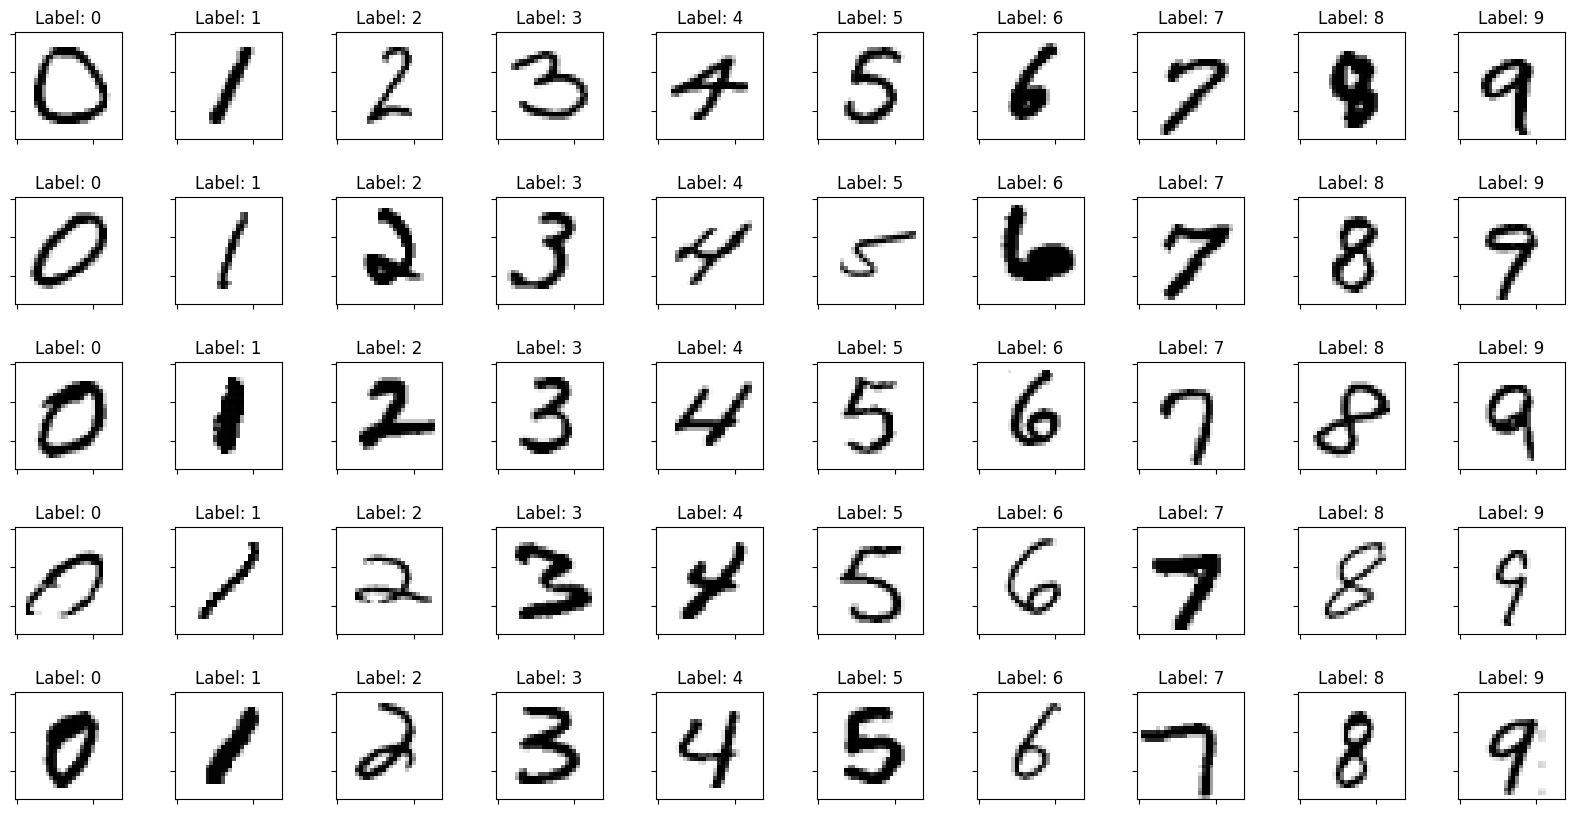

In [163]:
# display random examples of different digits
plt.style.use('default') 

rand_examples = np.array([np.random.choice(np.where(Y_train[j, :] == 1)[0], 
                                           size=5, replace=False) 
                                           for j in range(10)]).T
displayData(X_train, rand_examples, labels=list(np.argmax((Y_train), axis=0)))

In [172]:
from dougnet.MLP import MultLayerPerceptron
from dougnet.Activations import Relu, Tanh, SoftMax
from dougnet.Losses import SoftmaxCrossEntropyLoss, L2RegLoss
from dougnet.Scores import Accuracy

NNclf = MultLayerPerceptron([28*28, 40, 20, 10], 
                            [Relu, Tanh, SoftMax], 
                            SoftmaxCrossEntropyLoss,
                            reg = L2RegLoss,
                            B=100,
                            eta=.05,
                            n_epochs=100, 
                            lmbda=.1, 
                            seed=1984, 
                            progress_metric=Accuracy)

NNclf.fit(X_train, Y_train, X_val, Y_val);

100/100 | Train/Val. Loss: 4471.21/993.72 | Train/Val. Score: 98.26%/97.14% | Elapsed Time: 56.55 secondssss

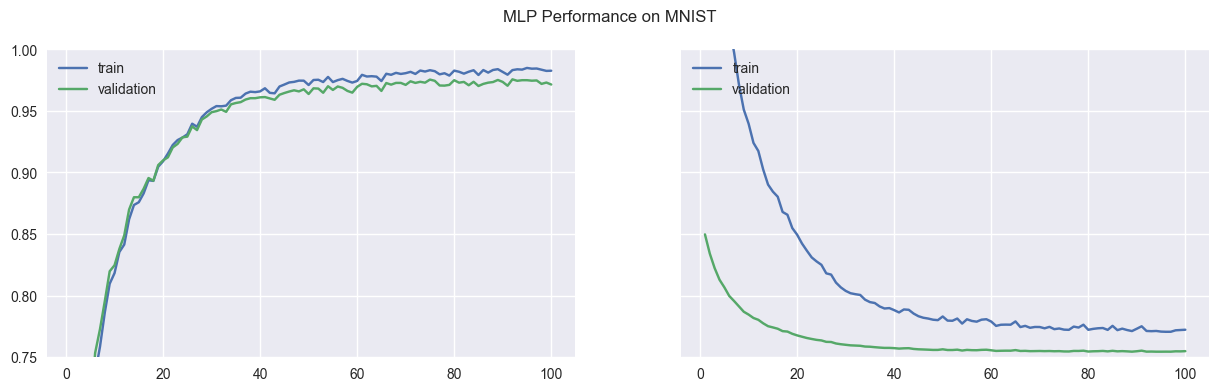

In [71]:
# plot training progress
plt.style.use('seaborn')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('MLP Performance on MNIST')

ax1.plot(range(1, len(NNclf.score_train_) + 1), NNclf.score_train_, 
         label='train')
ax1.plot(range(1, len(NNclf.score_train_) + 1), NNclf.score_val_, 
         label='validation')
ax1.set_ylim((.75, 1))
ax1.legend(loc="upper left")

ax2.plot(range(1, len(NNclf.score_train_) + 1), NNclf.loss_train_, 
         label='train')
ax2.plot(range(1, len(NNclf.score_train_) + 1), NNclf.loss_val_, 
         label='validation')
ax2.set_ylim((0, 50000))
ax2.axes.yaxis.set_ticklabels([])
ax2.legend(loc="upper left");

In [100]:
print(f'Expected Avg. Loss after first epoch ~ {round(np.log(10), 2)}')
print(f'Avg. Loss after first epoch = {round(NNclf.loss_train_[0] / 50000, 2)}')

Expected Avg. Loss after first epoch ~ 2.3
Avg. Loss after first epoch = 2.14


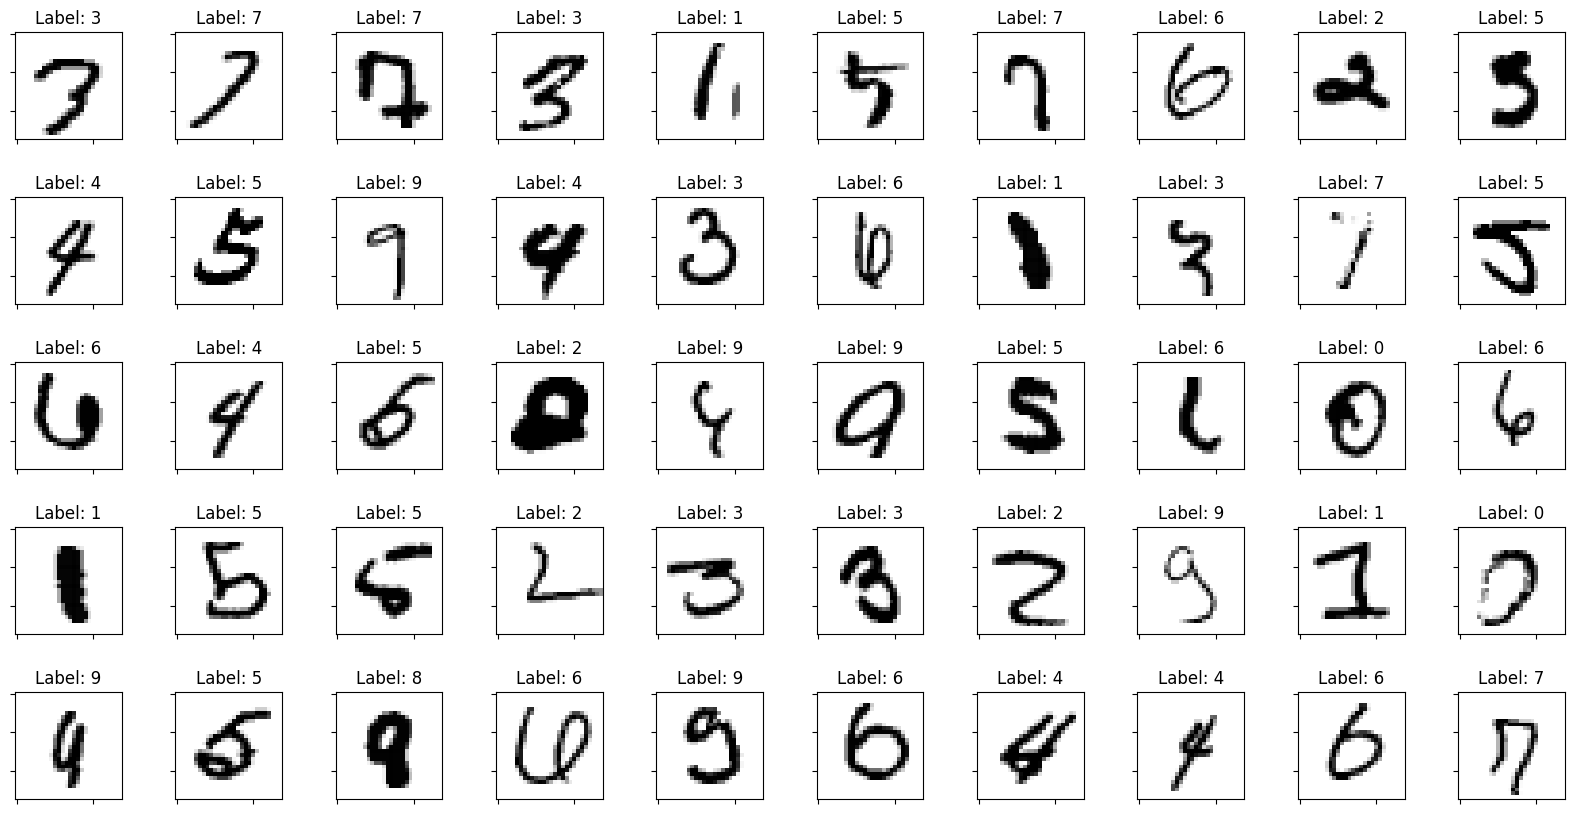

In [72]:
# display random examples of incorrect preds

plt.style.use('default') 

ypreds = np.argmax(NNclf.predict(X_val), axis=0)
yact = np.argmax(Y_val, axis=0)
incorrect_class = np.random.choice(np.where(yact != ypreds)[0], size=50, 
                                   replace=False).reshape(5, 10)

displayData(X_val, incorrect_class, labels=list(yact))

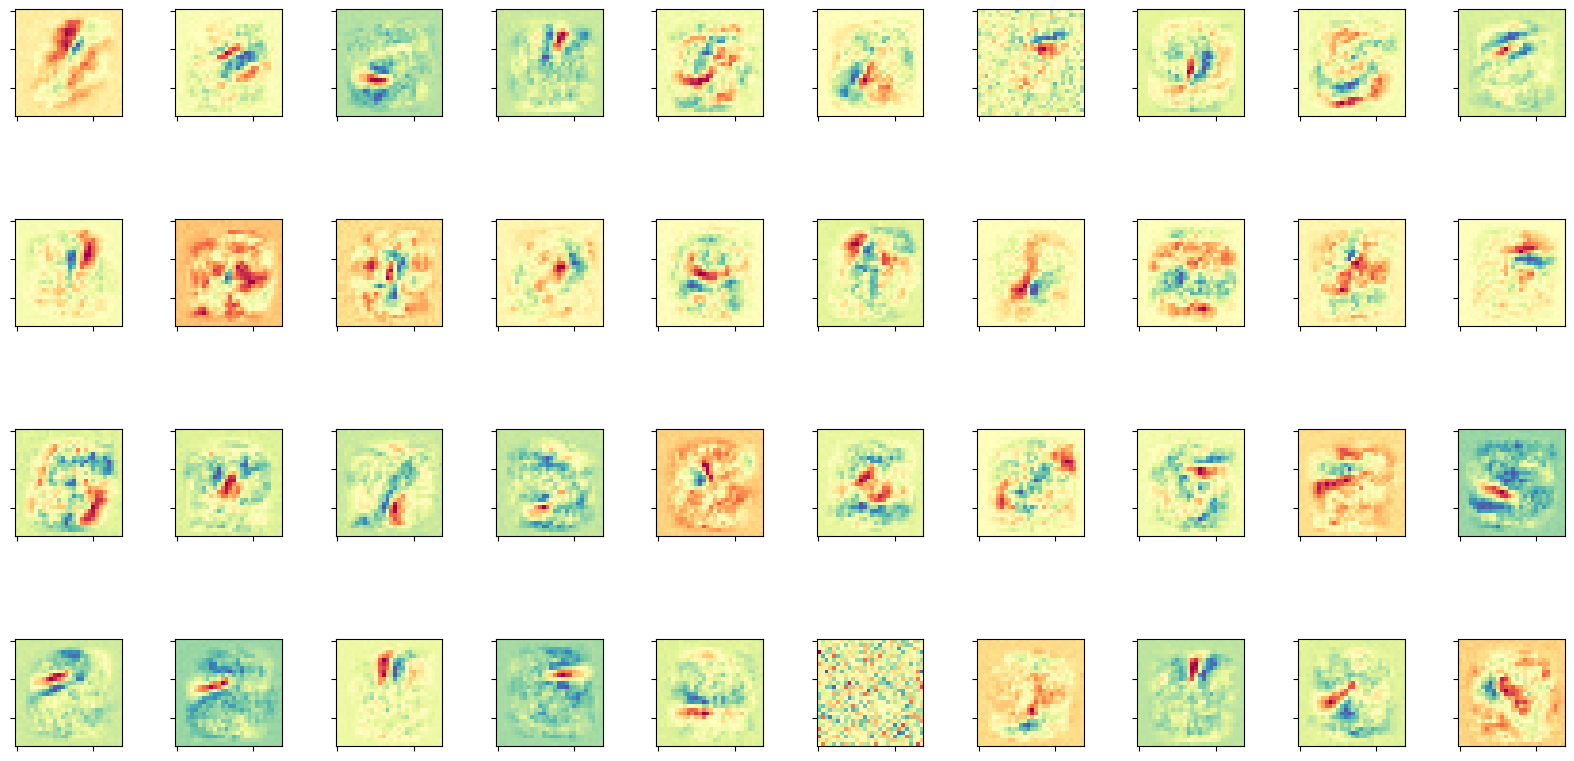

In [73]:
# display weights in first layer
displayData(NNclf.W[1].T, np.arange(NNclf.W[1].shape[0]).reshape(4, 10), 
            labels=False, cmap='Spectral') 

## Spiral Data Example

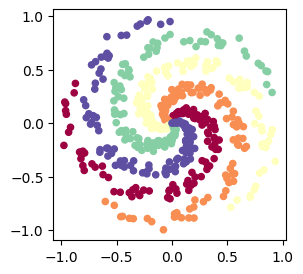

In [74]:
seed = 100
N = 100 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*5,(j+1)*5,N) + np.random.RandomState(seed).randn(N)*0.2 
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral);

In [75]:
X_pd, Y_ohe = PrepareData(X, y, 5)

X_train, Y_train = X_pd[:, 0:400], Y_ohe[:, 0:400]
X_val, Y_val = X_pd[:, 400:], Y_ohe[:, 400:]

In [76]:
NNclf = MultLayerPerceptron([2, 80, 50, 5], 
                            [Relu, Relu, SoftMax], 
                            SoftmaxCrossEntropyLoss,
                            reg = L2RegLoss,
                            B=100,
                            eta=.05,
                            n_epochs=100, 
                            lmbda=.1, 
                            seed=1984, 
                            progress_metric=Accuracy)

NNclf.fit(X_train, Y_train, X_val, Y_val);

100/100 | Train/Val. Loss: 475.70/426.97 | Train/Val. Score: 98.00%/98.00% | Elapsed Time: 0.41 secondsss

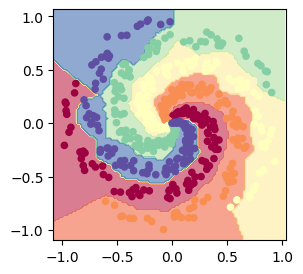

In [77]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X.T[0, :].min() - .1, X.T[0, :].max() + .1
y_min, y_max = X.T[1, :].min() - .1, X.T[1, :].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_grid = np.c_[xx.ravel(), yy.ravel()]
preds = np.argmax(NNclf.predict(X_grid.T), axis=0)

preds = preds.reshape(xx.shape)

plt.figure(figsize=(3, 3))
plt.contourf(xx, yy, preds, cmap=plt.cm.Spectral, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max);

## Regression Example

In [78]:
# create noisy sine data

f = lambda x: np.sin(x)
low, high = -10, 10

np.random.seed(2021)
X_train = np.random.uniform(low, high, 1000).reshape(1, 1000)
Y_train = f(X_train) + np.random.normal(0, .1, 1000).reshape(1, 1000)

X_val = np.random.uniform(low, high, 100).reshape(1, 100)
Y_val = f(X_val) + np.random.normal(0, .1, 100).reshape(1, 100)

In [79]:
from dougnet.Losses import L2Loss
from dougnet.Activations import Identity
from dougnet.Scores import R2

NNreg = MultLayerPerceptron([1, 100, 100, 1], 
                            [Tanh, Tanh, Identity], 
                            L2Loss,
                            reg = L2RegLoss,
                            B=100,
                            eta=.0005,
                            n_epochs=200, 
                            lmbda=.1, 
                            seed=1984, 
                            progress_metric=R2)

NNreg.fit(X_train, Y_train, X_val, Y_val);

200/200 | Train/Val. Loss: 1017.05/1017.06 | Train/Val. Score: 76.63%/68.52% | Elapsed Time: 3.51 secondsss

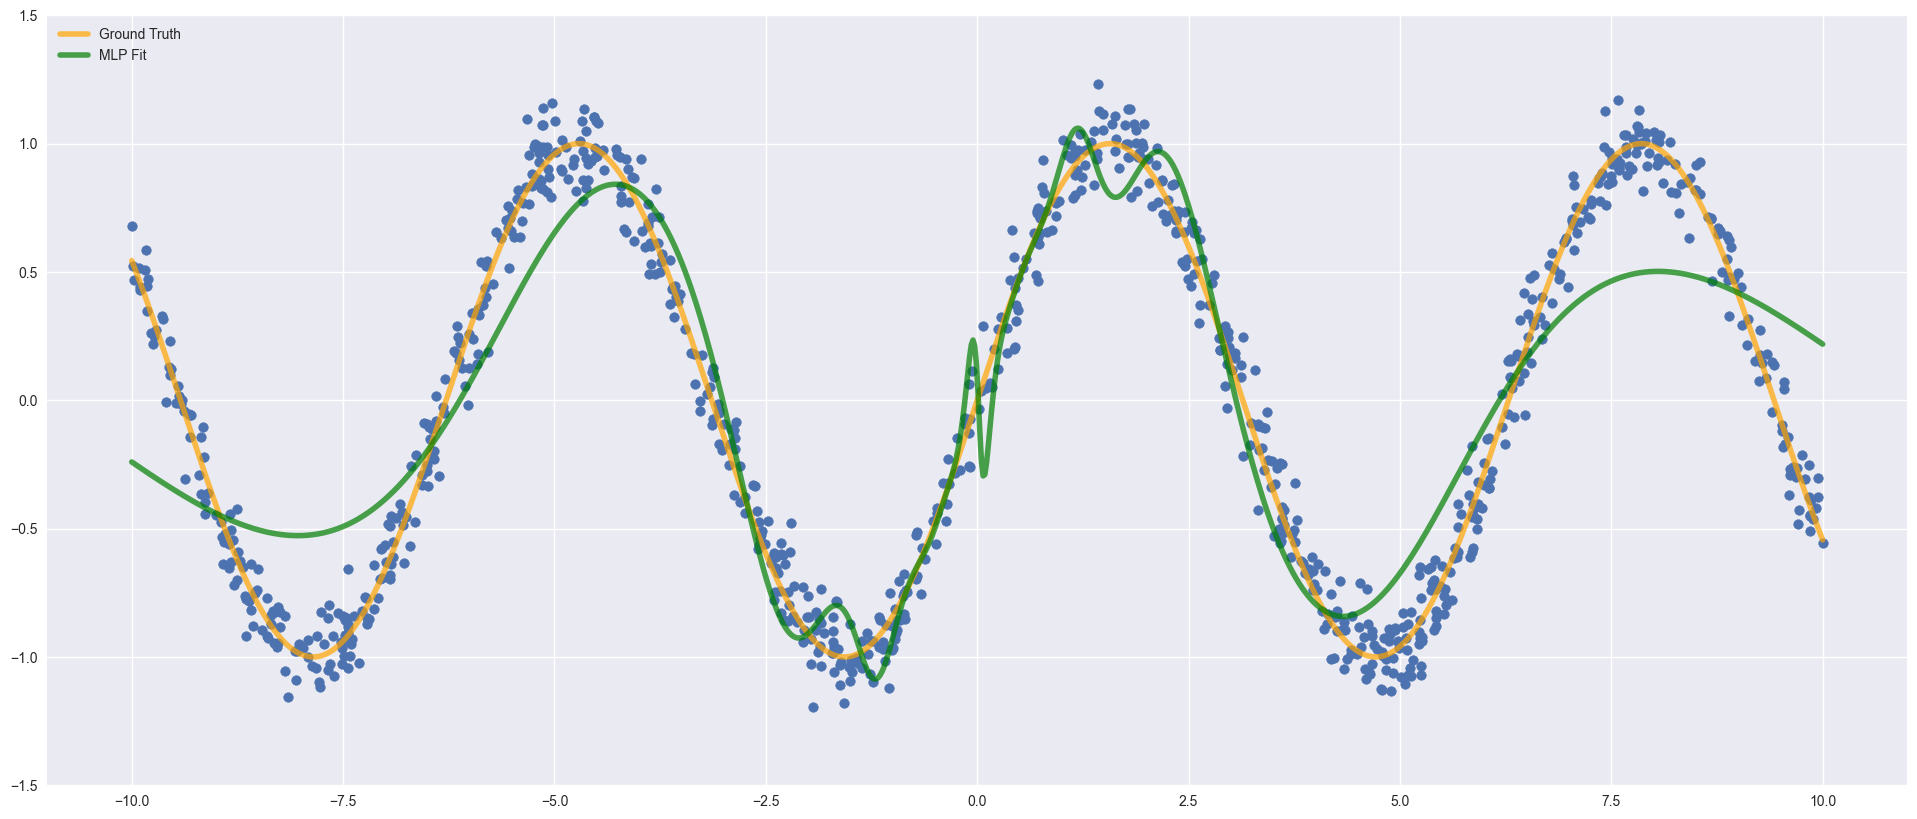

In [80]:
plt.style.use('seaborn')

x = np.linspace(low, high, 1000).reshape(1, 1000)
y = f(x).reshape(1, 1000)
              
plt.figure(figsize=(24, 10))
plt.scatter(X_train, Y_train)

plt.plot(x.reshape(1000), y.reshape(1000), color='orange', linewidth=4, 
         label='Ground Truth', alpha=.7)
plt.plot(x.reshape(1000), NNreg.predict(x).reshape(1000), color='green', 
         linewidth=4, label='MLP Fit', alpha=.7)
plt.legend(loc="upper left");
plt.ylim((-1.5, 1.5));